# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# %matplotlib inline 
%matplotlib notebook

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [17]:

MODEL_DIR

'/home/marziehhaghighi/workspace_DL/Mask_RCNN/logs'

In [2]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

In [3]:
# tf.compat.v1.disable_eager_execution()

## Configurations

In [2]:
class SpotsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "spots"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
#     IMAGE_SHAPE=1024
    
    IMAGE_MIN_DIM = 512#128
    IMAGE_MAX_DIM = 512#128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
#     n_clusters=5
    
    FPN_CLASSIF_FC_LAYERS_SIZE=1024;
    
config = SpotsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [11]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import matthews_corrcoef
print(normalized_mutual_info_score([1, 1, 0, 0], [0, 0, 1, 1]).astype('float32'))
print(matthews_corrcoef([1, 1, 0, 0], [0, 0, 1, 1]))

1.0
-1.0


In [36]:
# normalized_mutual_info_score([1,1], [1,0]).dtype
np.float32(1)

1.0

In [9]:
A=np.array([1, 4, 0, 0,5,0])
B=np.array([1, 5, 0, 0])
# A.shape
# B=np.zeros(A.shape)

In [11]:
A+1

array([2, 5, 1, 1, 6, 1])

In [10]:
non_zero_ind=np.where(A!=0)[0]
zero_ind=np.where(A==0)[0]
non_zero_ind, zero_ind

(array([0, 1, 4]), array([2, 3, 5]))

In [32]:
A1=A[A!=0]
A1

array([1, 4, 5])

In [3]:
# np.insert(A1, zero_ind, 0)

In [3]:
# import sklearn
# sklearn.metrics.consensus_score(A, B)

In [4]:
A=[1, 4, 0, 0]
B=[1, 5, 0, 0]
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('hamming')
X = [A,B]
dist.pairwise(X)[0,1]

0.25

In [44]:
dist.pairwise(X)

array([[0. , 0.5],
       [0.5, 0. ]])

In [10]:
a = np.array([1,2,3])
my_dict = {1:23, 2:34, 3:36, 4:45}
np.vectorize(my_dict.get)(a)


array([23, 34, 36])

In [42]:
dist.dist_to_rdist(X)

[[1, 2, 0, 0], [0, 0, 0, 0]]

In [31]:
matthews_corrcoef([1, 2, 0, 0], [0, 0, 0, 0])

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")
        self.add_class("shapes", 4, "ellipse")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        elif shape == "ellipse":
#             cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)
            cv2.ellipse(image, (x, y), (s,2*s),45,0, 360, color, -1)
            
            
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle", "ellipse"])
#         shape = random.choice(["square", "circle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 10
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
#         s = random.randint(buffer, height//4)
#         print(buffer, int(height//20))
        s = random.randint(buffer, 20)
#         print(s)
        return shape, color, (x, y, s)
    

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(10, 30)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [23]:
# dataset_val.image_ids
1024//20

51

In [28]:
dataset_val.source_class_ids

{'': [0], 'shapes': [0, 1, 2, 3]}

In [24]:
dataset_train.class_from_source_map

{'.0': 0, 'shapes.1': 1, 'shapes.2': 2, 'shapes.3': 3}

In [44]:
list(np.array([0,0,0]))==list(np.array([0,0,0]))

True

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="classification"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (8, ?)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)


In [6]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="clustering"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(16, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer:0", shape=(?, 32), dtype=int64)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)


In [8]:
# # Create model in training mode
# config.head='def'
# config.assign_label_mode ="clustering"#"clustering","classification"
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)

In [29]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit_transform([3,2,4,3,10]).shape

(5, 4)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
# Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
# dataset_train.

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200610T1259/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeD

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 299s 3s/step - loss: 4.3380 - rpn_class_loss: 0.4394 - rpn_bbox_loss: 1.1225 - mrcnn_class_loss: 0.7785 - mrcnn_bbox_loss: 0.8244 - mrcnn_mask_loss: 1.1730 - lambda_nmi: 0.7183 - val_loss: 2.3698 - val_rpn_class_loss: 0.1321 - val_rpn_bbox_loss: 0.7172 - val_mrcnn_class_loss: 0.5137 - val_mrcnn_bbox_loss: 0.3696 - val_mrcnn_mask_loss: 0.6371 - val_lambda_nmi: 0.7548
Epoch 2/100
100/100 [==============================] - 180s 2s/step - loss: 1.8791 - rpn_class_loss: 0.0992 - rpn_bbox_loss: 0.6310 - mrcnn_class_loss: 0.3775 - mrcnn_bbox_loss: 0.2351 - mrcnn_mask_loss: 0.5363 - lambda_nmi: 0.7796 - val_loss: 1.6744 - val_rpn_class_loss: 0.0853 - val_rpn_bbox_loss: 0.5908 - val_mrcnn_class_loss: 0.3299 - val_mrcnn_bbox_loss: 0.1954 - val_mrcnn_mask_loss: 0.4731 - val_lambda_nmi: 0.8271
Epoch 3/100
100/100 [==============================] - 184s 2s/step - loss: 1.5243 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.5517 - mrcnn_class_loss: 0.3393 - mrc

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100/100 [==============================] - 184s 2s/step - loss: 0.5135 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1663 - mrcnn_class_loss: 0.2078 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0859 - lambda_nmi: 0.8834 - val_loss: 0.5902 - val_rpn_class_loss: 0.0179 - val_rpn_bbox_loss: 0.2043 - val_mrcnn_class_loss: 0.2192 - val_mrcnn_bbox_loss: 0.0470 - val_mrcnn_mask_loss: 0.1018 - val_lambda_nmi: 0.8752
Epoch 42/100
100/100 [==============================] - 182s 2s/step - loss: 0.5342 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1813 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0930 - lambda_nmi: 0.8778 - val_loss: 0.5108 - val_rpn_class_loss: 0.0177 - val_rpn_bbox_loss: 0.2020 - val_mrcnn_class_loss: 0.1463 - val_mrcnn_bbox_loss: 0.0475 - val_mrcnn_mask_loss: 0.0973 - val_lambda_nmi: 0.9276
Epoch 43/100
100/100 [==============================] - 183s 2s/step - loss: 0.5174 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1682 - mrcnn_class_loss: 0.2098 - m

100/100 [==============================] - 186s 2s/step - loss: 0.4209 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.1834 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0752 - lambda_nmi: 0.9015 - val_loss: 0.4641 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 0.1598 - val_mrcnn_class_loss: 0.1769 - val_mrcnn_bbox_loss: 0.0345 - val_mrcnn_mask_loss: 0.0763 - val_lambda_nmi: 0.8980
Epoch 80/100
100/100 [==============================] - 182s 2s/step - loss: 0.3999 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.1546 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0802 - lambda_nmi: 0.9135 - val_loss: 0.4746 - val_rpn_class_loss: 0.0163 - val_rpn_bbox_loss: 0.1598 - val_mrcnn_class_loss: 0.1849 - val_mrcnn_bbox_loss: 0.0354 - val_mrcnn_mask_loss: 0.0782 - val_lambda_nmi: 0.8852
Epoch 81/100
100/100 [==============================] - 183s 2s/step - loss: 0.3930 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.1520 - m

Process ForkPoolWorker-49:
Process ForkPoolWorker-19:
Process ForkPoolWorker-59:
Process ForkPoolWorker-47:
Process ForkPoolWorker-63:
Process ForkPoolWorker-51:
Process ForkPoolWorker-58:
Process ForkPoolWorker-17:
Process ForkPoolWorker-27:
Process ForkPoolWorker-46:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-62:
Traceback (most recent call last):
Process ForkPoolWorker-57:
Process ForkPoolWorker-44:
Process ForkPoolWorker-48:
Process ForkPoolWorker-61:
Process ForkPoolWorker-54:
Traceback (most recent call last):
Process ForkPoolWorker-53:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-50:
Process ForkPoolWorker-3:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Tra

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-41:
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _

  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File 

  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **s

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py", line 641, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker

Process ForkPoolWorker-77:
Process ForkPoolWorker-73:
Process ForkPoolWorker-86:
Process ForkPoolWorker-84:
Process ForkPoolWorker-103:
Process ForkPoolWorker-89:
Process ForkPoolWorker-96:
Process ForkPoolWorker-70:
Process ForkPoolWorker-92:
Process ForkPoolWorker-87:
Process ForkPoolWorker-81:
Process ForkPoolWorker-80:
Process ForkPoolWorker-10:
Process ForkPoolWorker-90:
Process ForkPoolWorker-85:
Process ForkPoolWorker-71:
Process ForkPoolWorker-88:
Process ForkPoolWorker-76:
Process ForkPoolWorker-99:
Process ForkPoolWorker-78:
Process ForkPoolWorker-104:
Process ForkPoolWorker-102:
Process ForkPoolWorker-148:
Process ForkPoolWorker-147:
Process ForkPoolWorker-146:
Process ForkPoolWorker-134:
Process ForkPoolWorker-152:
Process ForkPoolWorker-161:
Process ForkPoolWorker-151:
Process ForkPoolWorker-162:
Process ForkPoolWorker-133:
Process ForkPoolWorker-155:
Process ForkPoolWorker-165:
Process ForkPoolWorker-174:
Process ForkPoolWorker-159:
Process ForkPoolWorker-137:
Process For

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    sel

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task 

KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessi

In [17]:
# import tensorflow as tf
# tf.__version__
# # tf.compat.v2
# tf.contrib.summary.create_file_writer

In [1]:
from sklearn.preprocessing import label_binarize
x=label_binarize([1, 6], classes=range(7))
x

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

In [7]:
# x.flatten().shape
import numpy as np
x=np.zeros(5)

In [8]:
x.shape

(5,)

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200601T2133/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 442s 4s/step - loss: 1.5674 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.7043 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2533 - mrcnn_mask_loss: 0.2684 - val_loss: 0.8294 - val_rpn_class_loss: 0.0342 - val_rpn_bbox_loss: 0.5035 - val_mrcnn_class_loss: 0.0948 - val_mrcnn_bbox_loss: 0.1104 - val_mrcnn_mask_loss: 0.0866


In [ ]:
 1/100 [..............................] - ETA: 3:59:11 - loss: nan - rpn_class_loss: 0.4325 - rpn_bbox_loss: 1.6060 - mrcnn_class_loss: nan - mrcnn_bbox_loss: 2.4804 - mrcnn_mask_loss: 0.4483Input Shape (8, 32, 1024)

In [ ]:
 45/100 [============>.................] - ETA: 5:44 - loss: 2.4823 - rpn_class_loss: 0.2034 - rpn_bbox_loss: 0.9265 - mrcnn_class_loss: 0.4083 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.4922

In [21]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=10*config.LEARNING_RATE ,#/ 10,
            epochs=40, 
            layers="all")


Starting at epoch 0. LR=0.01

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200609T1711/mask_rcnn_spots_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
100/100 [==============================] - 259s 3s/step - loss: 3.6343 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 0.7737 - mrcnn_class_loss: 1.0929 - mrcnn_bbox_loss: 1.0164 - mrcnn_mask_loss: 0.6362 - lambda_nmi: 0.6193 - val_loss: 2.3214 - val_rpn_class_loss: 0.0433 - val_rpn_bbox_loss: 0.5232 - val_mrcnn_class_loss: 0.7909 - val_mrcnn_bbox_loss: 0.4885 - val_mrcnn_mask_loss: 0.4754 - val_lambda_nmi: 0.6117
Epoch 2/40
100/100 [==============================] - 179s 2s/step - loss: 1.7690 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.6852 - mrcnn_bbox_loss: 0.4632 - mrcnn_mask_loss: 0.3798 - lambda_nmi: 0.6314 - val_loss: 1.9758 - val_rpn_class_loss: 0.0307 - val_rpn_bbox_loss: 0.4844 - val_mrcnn_class_loss: 0.6587 - val_mrcnn_bbox_loss: 0.4779 - val_mrcnn_mask_loss: 0.3240 - val_lambda_nmi: 0.6671
Epoch 3/40
100/100 [==============================] - 179s 2s/step - loss: 1.3653 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1617 - mrcnn_class_loss: 0.5

Process ForkPoolWorker-61:
Process ForkPoolWorker-56:
Process ForkPoolWorker-55:
Process ForkPoolWorker-3:
Process ForkPoolWorker-46:
Process ForkPoolWorker-1:
Process ForkPoolWorker-60:
Process ForkPoolWorker-45:
Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Traceback (most recent call last):
Process ForkPoolWorker-14:
Process ForkPoolWorker-49:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-42:
Traceback (most recent call last):
Process ForkPoolWorker-19:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-59:
Traceback (most recent call last):
Process ForkPoolWorker-43:
Process ForkPoolWorker-52:
Process ForkPoolWorker-63:
Process ForkPoolWorker-37:
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", l

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = ge

  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Process ForkPoolWorker-36:
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python

Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap


  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [8]:
class InferenceConfig(SpotsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head='def'
inference_config.assign_label_mode="clustering"
inference_config.DETECTION_MIN_CONFIDENCE=0.7
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

shared Tensor("pool_squeeze_2/Squeeze_1:0", shape=(?, 1000, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_2/Reshape_1:0", shape=(?, 1000, 5), dtype=float32)
Loading weights from  /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/spots20200610T1259/mask_rcnn_spots_0083.h5
Re-starting from epoch 83


In [53]:
model.load_weights(model_path, by_name=True)

Re-starting from epoch 1


In [12]:
original_image.dtype

dtype('uint8')

original_image           shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (25,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (25, 4)               min:    8.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 25)        min:    0.00000  max:    1.00000  bool


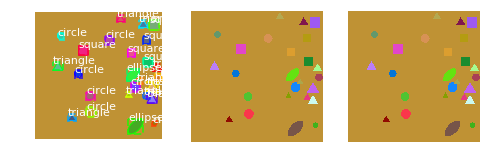

In [9]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [14]:
gt_class_id

array([2, 3, 4, 4, 2, 2, 3, 2, 4, 3, 3, 4, 2, 3, 4, 4, 4, 3, 2, 1, 2, 2,
       1, 2, 1, 3, 2], dtype=int32)

In [11]:
r['class_ids']

array([], dtype=int32)

In [16]:
# r['rois']

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
image_meta (17,) [  0 512 512   3 512 512   3   0   0 512 512   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  149.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


<IPython.core.display.Javascript object>


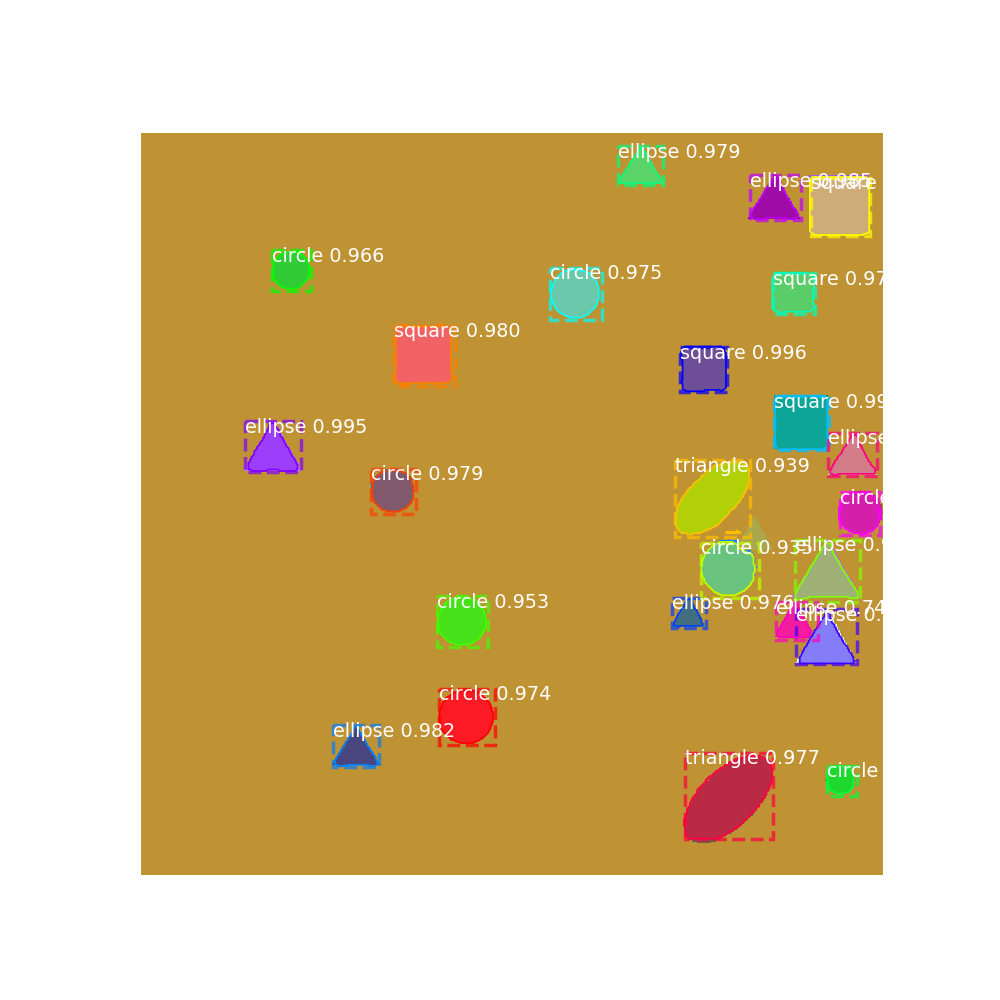

In [10]:
%matplotlib notebook
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [30]:
results

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [60]:
# results

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95


In [ ]:
Function for classification loss
def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):
    """Loss for the classifier head of Mask RCNN.

    target_class_ids: [batch, num_rois]. Integer class IDs. Uses zero
        padding to fill in the array.
    pred_class_logits: [batch, num_rois, num_classes]
    active_class_ids: [batch, num_classes]. Has a value of 1 for
        classes that are in the dataset of the image, and 0
        for classes that are not in the dataset.

In [ ]:
class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
    [target_class_ids, mrcnn_class_logits, active_class_ids])

In [ ]:
rois, target_class_ids, target_bbox, target_mask =\
    DetectionTargetLayer(config, name="proposal_targets")([
        target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

In [ ]:
class DetectionTargetLayer(KE.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

In [ ]:
I want to manipulate conversion of "gt_class_ids" to "target_class_ids"\
in the above function for clustering samples and reassign the labels 

In [16]:
# import tensorflow as tf
from tensorflow.contrib.factorization import KMeans

/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Change:
mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                     config.POOL_SIZE, config.NUM_CLASSES,
                     train_bn=config.TRAIN_BN,
                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

In [ ]:
# ------------------------------------------
# TensorFlow Implementation for kmeans
# ------------------------------------------
# Extract the features from the training data
feats = tf.contrib.learn.infer_real_valued_columns_from_input(x_train)
# Building a 3-layer DNN with 50 units each.
classifier_tf = tf.contrib.learn.DNNClassifier(feature_columns=feats, 
                                               hidden_units=[50, 50, 50], 
                                               n_classes=3)
# Use the train data to train this classifier
classifier_tf.fit(x_train, y_train, steps=5000)
# Use the trained model to predict on the test data
predictions = list(classifier_tf.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, predictions)

In [22]:
tf.contrib.learn.infer_real_valued_columns_from_input

<function tensorflow.contrib.learn.python.learn.estimators.estimator.infer_real_valued_columns_from_input(x)>

In [ ]:
kmeans = tf.contrib.factorization.KMeans(
  inp,
  num_clusters,
  distance_metric=tf.contrib.factorization.COSINE_DISTANCE,
  # TODO(agarwal): kmeans++ is currently causing crash in dbg mode.
  # Enable this after fixing.
  # initial_clusters=tf.contrib.factorization.KMEANS_PLUS_PLUS_INIT,
  use_mini_batch=True)

all_scores, _, clustering_scores, kmeans_training_op = kmeans.training_graph()

In [26]:
tf.contrib.learn.KMeans

AttributeError: module 'tensorflow.contrib.learn' has no attribute 'KMeans'

In [27]:
tf.contrib.factorization.KMeansClustering

tensorflow.contrib.factorization.python.ops.kmeans.KMeansClustering

In [4]:
k = 5
n = 100
variables = 2
points = np.random.uniform(0, 1000, [n, variables])
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)
kmeans=tf.contrib.factorization.KMeansClustering(num_clusters=k, use_mini_batch=False)
previous_centers = None
# for _ in range(10):
kmeans.train(input_fn)
centers = kmeans.cluster_centers()
#   if previous_centers is not None:
#     print 'delta:', centers - previous_centers
#   previous_centers = centers
#   print 'score:', kmeans.score(input_fn)
# print 'centers:', centers
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
#   print 'point:', point, 'is in cluster', cluster_index, 'centered at', centers[cluster_index]

NameError: name 'tf' is not defined

In [41]:
len(cluster_indices)

100

In [47]:
testT=tf.convert_to_tensor(points, dtype=tf.float32)
testT

<tf.Tensor 'Const_4:0' shape=(100, 2) dtype=float32>

In [53]:
tf.reshape(
    testT, (testT.shape[1],testT.shape[0]), name=None
)

<tf.Tensor 'Reshape_7:0' shape=(2, 100) dtype=float32>

Dimension(100)

# Clustering details:
- test both of the following, when doing clustering at each iteration:
    - Predict based on random initialization at first at the first iteration, then for the next one instialize clusters based on predictions 
    - At each iteration permute labels so that it has the minimum hamming distance to the predicted ones 

In [18]:
cost = np.array([[4, 1, 3],
                 [2, 0, 5],
                 [3, 2, 2],
                 [3, 2, 2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)
col_ind


array([1, 0, 2])

In [17]:
Input Shape (8, 32, 1024)

array([1, 3, 4])

In [ ]:
X=np.array([[[1,1,1],[2,2,2],[3,3,3]],
           [[4,4,4],[5,5,5],[6,6,6]],
           [[7,7,7],[8,8,8],[9,9,9]],
           [[10,10,10],[11,11,11],[12,12,12]]])

In [28]:
X1=np.array([[1,2,3],
           [4,5,6],
           [7,8,9],
           [10,11,12]])




In [30]:
X1.flatten()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [26]:
X.shape

(4, 3, 3)

In [27]:
X.reshape([12,3])

array([[ 1,  1,  1],
       [ 2,  2,  2],
       [ 3,  3,  3],
       [ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       [ 7,  7,  7],
       [ 8,  8,  8],
       [ 9,  9,  9],
       [10, 10, 10],
       [11, 11, 11],
       [12, 12, 12]])

In [16]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# kmeans.labels_
# array([1, 1, 1, 0, 0, 0], dtype=int32)
# kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)
cents=kmeans.cluster_centers_
cents

array([[10.,  3.],
       [ 1.,  2.],
       [10.,  0.]])

In [42]:
from numpy import linalg as LA
np.argmin(LA.norm(cents-[10,0],1,axis=1))

2

In [19]:
list(kmeans.labels_).remove(0)

In [23]:
b=list(kmeans.labels_)
b.remove(0)
b

[1, 1, 1, 0, 2]

In [22]:
b